In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [3]:
matplotlib.style.use('ggplot')
matplotlib.style.use('seaborn-notebook')
plt.rcParams['figure.figsize'] = (14.0, 11.0)

In [4]:
import dmc

In [5]:
dft = dmc.loading.data_train()
dfc = dmc.loading.data_class()

In [15]:
dft = dft.dropna(subset=['voucherID', 'rrp', 'productGroup'])
dfc = dfc.dropna(subset=['voucherID', 'rrp', 'productGroup'])

## Categorical discrepancies between training and target set
Investigated _articleID_, _colorCode_, _sizeCode_, _productGroup_, _quantity_, _voucherID_, _customerID_, _deviceID_, _paymentMethod_.
The following definitely fully appear in the training set:
**sizeCode, quantity, deviceID, paymentMethod**. Thus, in this version of the notebook they are left out. To proove the point the methods below can be used to profile columns.

In [19]:
inv_features = ['articleID', 'colorCode', 'productGroup', 'voucherID', 'customerID']

In [13]:
def count_entries(data, features):
    profile = []
    for feat in features:
        profile.append((feat, data.count(feat)))
    return profile

def profile_dfc(column, known, unknown):
    entries = list(dfc[column])
    known_prof = count_entries(entries, known)
    unknown_prof = count_entries(entries, unknown)
    print(len(known), ' features are known and ', len(unknown), ' features are not')
    known_amt, unknown_amt = sum([e[1] for e in known_prof]), sum([e[1] for e in unknown_prof])
    print('Ratio unknown:known for rows: ', unknown_amt/known_amt)
    print(known_amt/len(entries), '% of the rows features are known')
    print(unknown_amt/len(entries), '% of the rows features are not known')
    
def diff(column):
    unknown = set(dfc[column]) - set(dft[column])
    known = set(dfc[column]) - unknown
    return known, unknown
    
def diff_and_profile(column):
    known, unknown = diff(column)
    profile_dfc(column, known, unknown)

In [20]:
for feature in inv_features:
    print(feature)
    diff_and_profile(feature)

articleID
1154  features are known and  418  features are not
Ratio unknown:known for rows:  0.45969675176794916
0.685073799601749 % of the rows features are known
0.314926200398251 % of the rows features are not known
colorCode
239  features are known and  96  features are not
Ratio unknown:known for rows:  0.25145333900967426
0.7990709432213754 % of the rows features are known
0.20092905677862466 % of the rows features are not known
productGroup
15  features are known and  13  features are not
Ratio unknown:known for rows:  0.2259292681260763
0.8157077459522392 % of the rows features are known
0.18429225404776078 % of the rows features are not known
voucherID
34  features are known and  110  features are not
Ratio unknown:known for rows:  0.2701743276465768
0.7872935062802244 % of the rows features are known
0.2127064937197756 % of the rows features are not known
customerID
42342  features are known and  30603  features are not
Ratio unknown:known for rows:  0.4476435900810447
0.6907

In [21]:
knownGroup, uknownGroup = diff('productGroup')
knownArt, uknownArt = diff('articleID')

In [30]:
# all new productGroups contain new articles. New articles caused new productGroups indeed
for group in uknownGroup:
    art_set = set(dfc.articleID[dfc.productGroup == group])
    dif = art_set - knownArt
    print(len(dif), len(art_set))

2 2
19 19
3 3
2 2
22 22
32 32
29 29
30 30
69 69
26 26
6 6
46 46
23 23


In [35]:
known = []
for art in unknownArt:
    group = set(dfc.productGroup[dfc.articleID == art]).pop()
    if group in knownGroup:
        known.append(group)
len(known), set(known)

(109,
 {1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 13.0, 14.0, 17.0, 45.0, 50.0})

1. _articleID_ might be interesting compared to _productGroup_ (are there articles which we can just add to a previously known productGroup? if it is unkown?). For _productGroup_ this is interesting because we may find a similar productGroup we can get the returnProbability from.
2. _colorCode_ might be mappable and probably we can use bins that contain old and new colors in order to make a semantic split with regard to returnQuantity.
3. _voucherID_ is an extremely risky feature since we only know 20% of the occurring vouchers in our target set. Thus we should teadiously reason why we want to keep that feature or if we want to.
4. _customerID_ shows us that we can learn more about customers and it pays out for 70%. Also we should learn about first-time customer behavior in order to classify the other 30% better.
### ColorCode investigation

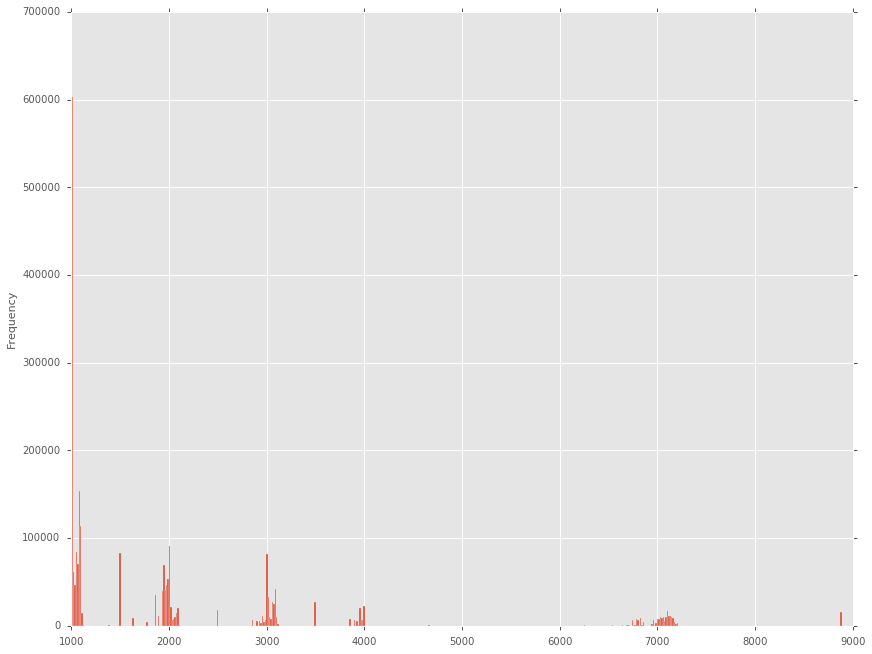

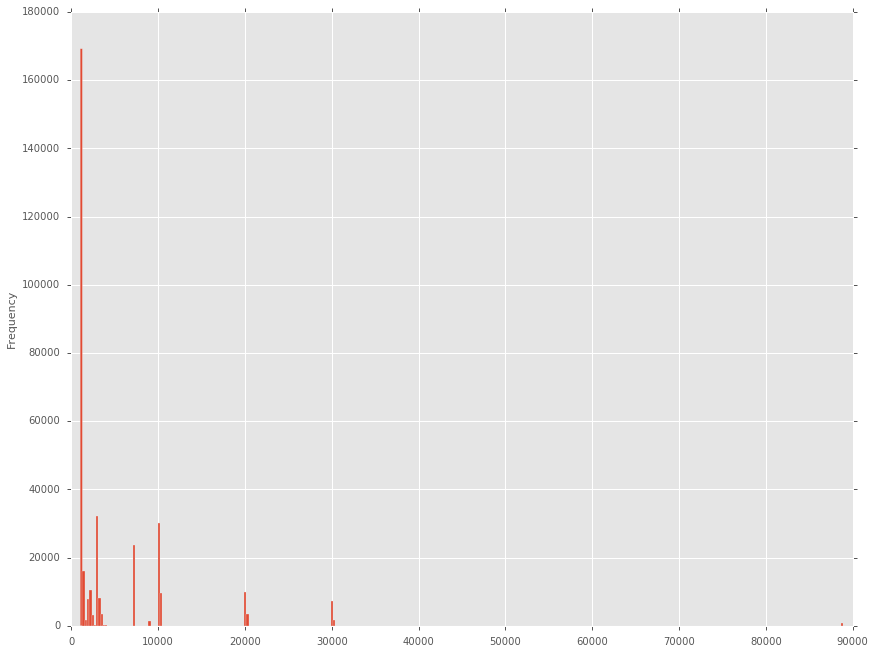

In [54]:
dft.colorCode.plot.hist(bins=len(set(dft.colorCode)))
plt.show()
dfc.colorCode.plot.hist(bins=len(set(dfc.colorCode)))
plt.show()

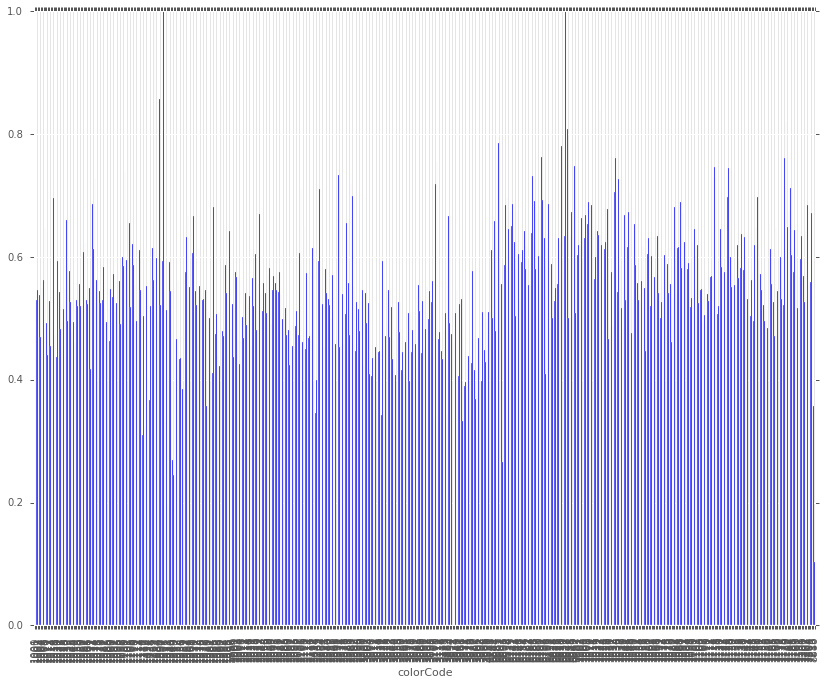

In [51]:
returned_articles = dft.groupby(['colorCode']).returnQuantity.sum()
bought_articles = dft.groupby(['colorCode']).quantity.sum()
group_return_probs = returned_articles / bought_articles
axes = group_return_probs.sort_index().plot('bar')